# Baseline Model

## Imports and read data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

In [3]:
# Load data
df = pd.read_csv('../data/daily_merged_hydro_climate.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   date                            136409 non-null  object 
 1   Source                          136409 non-null  object 
 2   current_mean                    136409 non-null  float64
 3   current_max                     136409 non-null  float64
 4   current_std                     136409 non-null  float64
 5   power_factor_mean               136409 non-null  float64
 6   kwh_sum                         136409 non-null  float64
 7   Temperature (°C)_mean           136409 non-null  float64
 8   Temperature (°C)_min            136409 non-null  float64
 9   Temperature (°C)_max            136409 non-null  float64
 10  Dewpoint Temperature (°C)_mean  136409 non-null  float64
 11  Dewpoint Temperature (°C)_min   136409 non-null  float64
 12  Dewpoint Tempera

In [5]:
df['date'] = pd.to_datetime(df['date'])
print(df.date.max())
print(df.date.min())

2024-09-23 00:00:00
2023-06-03 00:00:00


In [6]:
print(df.info(show_counts=True))
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            136409 non-null  datetime64[ns]
 1   Source                          136409 non-null  object        
 2   current_mean                    136409 non-null  float64       
 3   current_max                     136409 non-null  float64       
 4   current_std                     136409 non-null  float64       
 5   power_factor_mean               136409 non-null  float64       
 6   kwh_sum                         136409 non-null  float64       
 7   Temperature (°C)_mean           136409 non-null  float64       
 8   Temperature (°C)_min            136409 non-null  float64       
 9   Temperature (°C)_max            136409 non-null  float64       
 10  Dewpoint Temperature (°C)_mean  136409 non-null  float64

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
136404,2024-09-23,consumer_device_8_data_user_10,0.086007,0.10,0.010036,0.744965,0.316940,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_8,10,203.113368,1,0,0
136405,2024-09-23,consumer_device_28_data_user_10,8.006736,23.97,4.669972,0.728542,26.101382,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_28,10,181.688160,1,0,0
136406,2024-09-23,consumer_device_10_data_user_13,0.015000,0.07,0.022770,0.220486,0.048129,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_10,13,190.297118,1,0,0
136407,2024-09-23,consumer_device_36_data_user_16,0.070069,0.08,0.004495,0.747569,0.261421,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_36,16,206.630625,0,0,1
136408,2024-09-23,consumer_device_22_data_user_12,0.023611,0.05,0.024526,0.354340,0.062540,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_22,12,104.095278,1,0,0


In [7]:
df_train = df.loc[df.date <= pd.to_datetime('2024-08-23 23:00:00'),:]
df_test = df.loc[df.date > pd.to_datetime('2024-08-23 23:00:00'),:]

In [8]:
print(df_train[['date', 'Source']].head(1))
print(df_train[['date', 'Source']].tail(1))
print(df_test[['date', 'Source']].head(1))
print(df_test[['date', 'Source']].tail(1))

        date                         Source
0 2023-06-03  consumer_device_3_data_user_9
             date                           Source
124775 2024-08-23  consumer_device_28_data_user_11
             date                           Source
124776 2024-08-24  consumer_device_24_data_user_10
             date                           Source
136408 2024-09-23  consumer_device_22_data_user_12


In [9]:
def wind_convert(u, v):

    speed = np.sqrt(u**2 + v**2)
    direction = np.arctan2(-u,-v)
    direction2 = direction * 180/np.pi

    return direction, direction2, speed


In [10]:
x, y, z = wind_convert(df['U Wind Component (m/s)_mean'], df['V Wind Component (m/s)_mean'])
df_wind = df[['date', 'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean']].copy()
df_wind['direction'] = x
df_wind['direction_degree'] = y
df_wind['speed'] = z

In [11]:
df_wind.head(40)

,date,U Wind Component (m/s)_mean,V Wind Component (m/s)_mean,direction,direction_degree,speed
0,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
1,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
2,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
3,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
4,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
5,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
6,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
7,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
8,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203
9,2023-06-03,0.025054,-0.657726,-0.038073,-2.181408,0.658203


In [12]:
df_kwh_h_sum = df.groupby('date').agg({
    "kwh_sum": "sum"
})

In [17]:
df_kwh_h_sum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 479 entries, 2023-06-03 to 2024-09-23
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   kwh_sum  479 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB


In [14]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

<Axes: xlabel='date'>

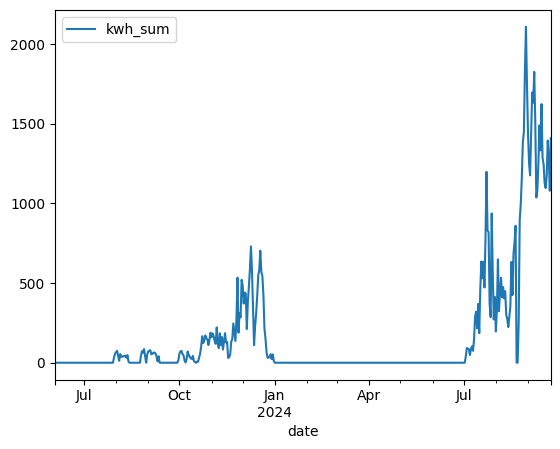

In [15]:
df_kwh_h_sum.plot(kind='line')

<Axes: title={'center': 'Close'}, xlabel='date'>

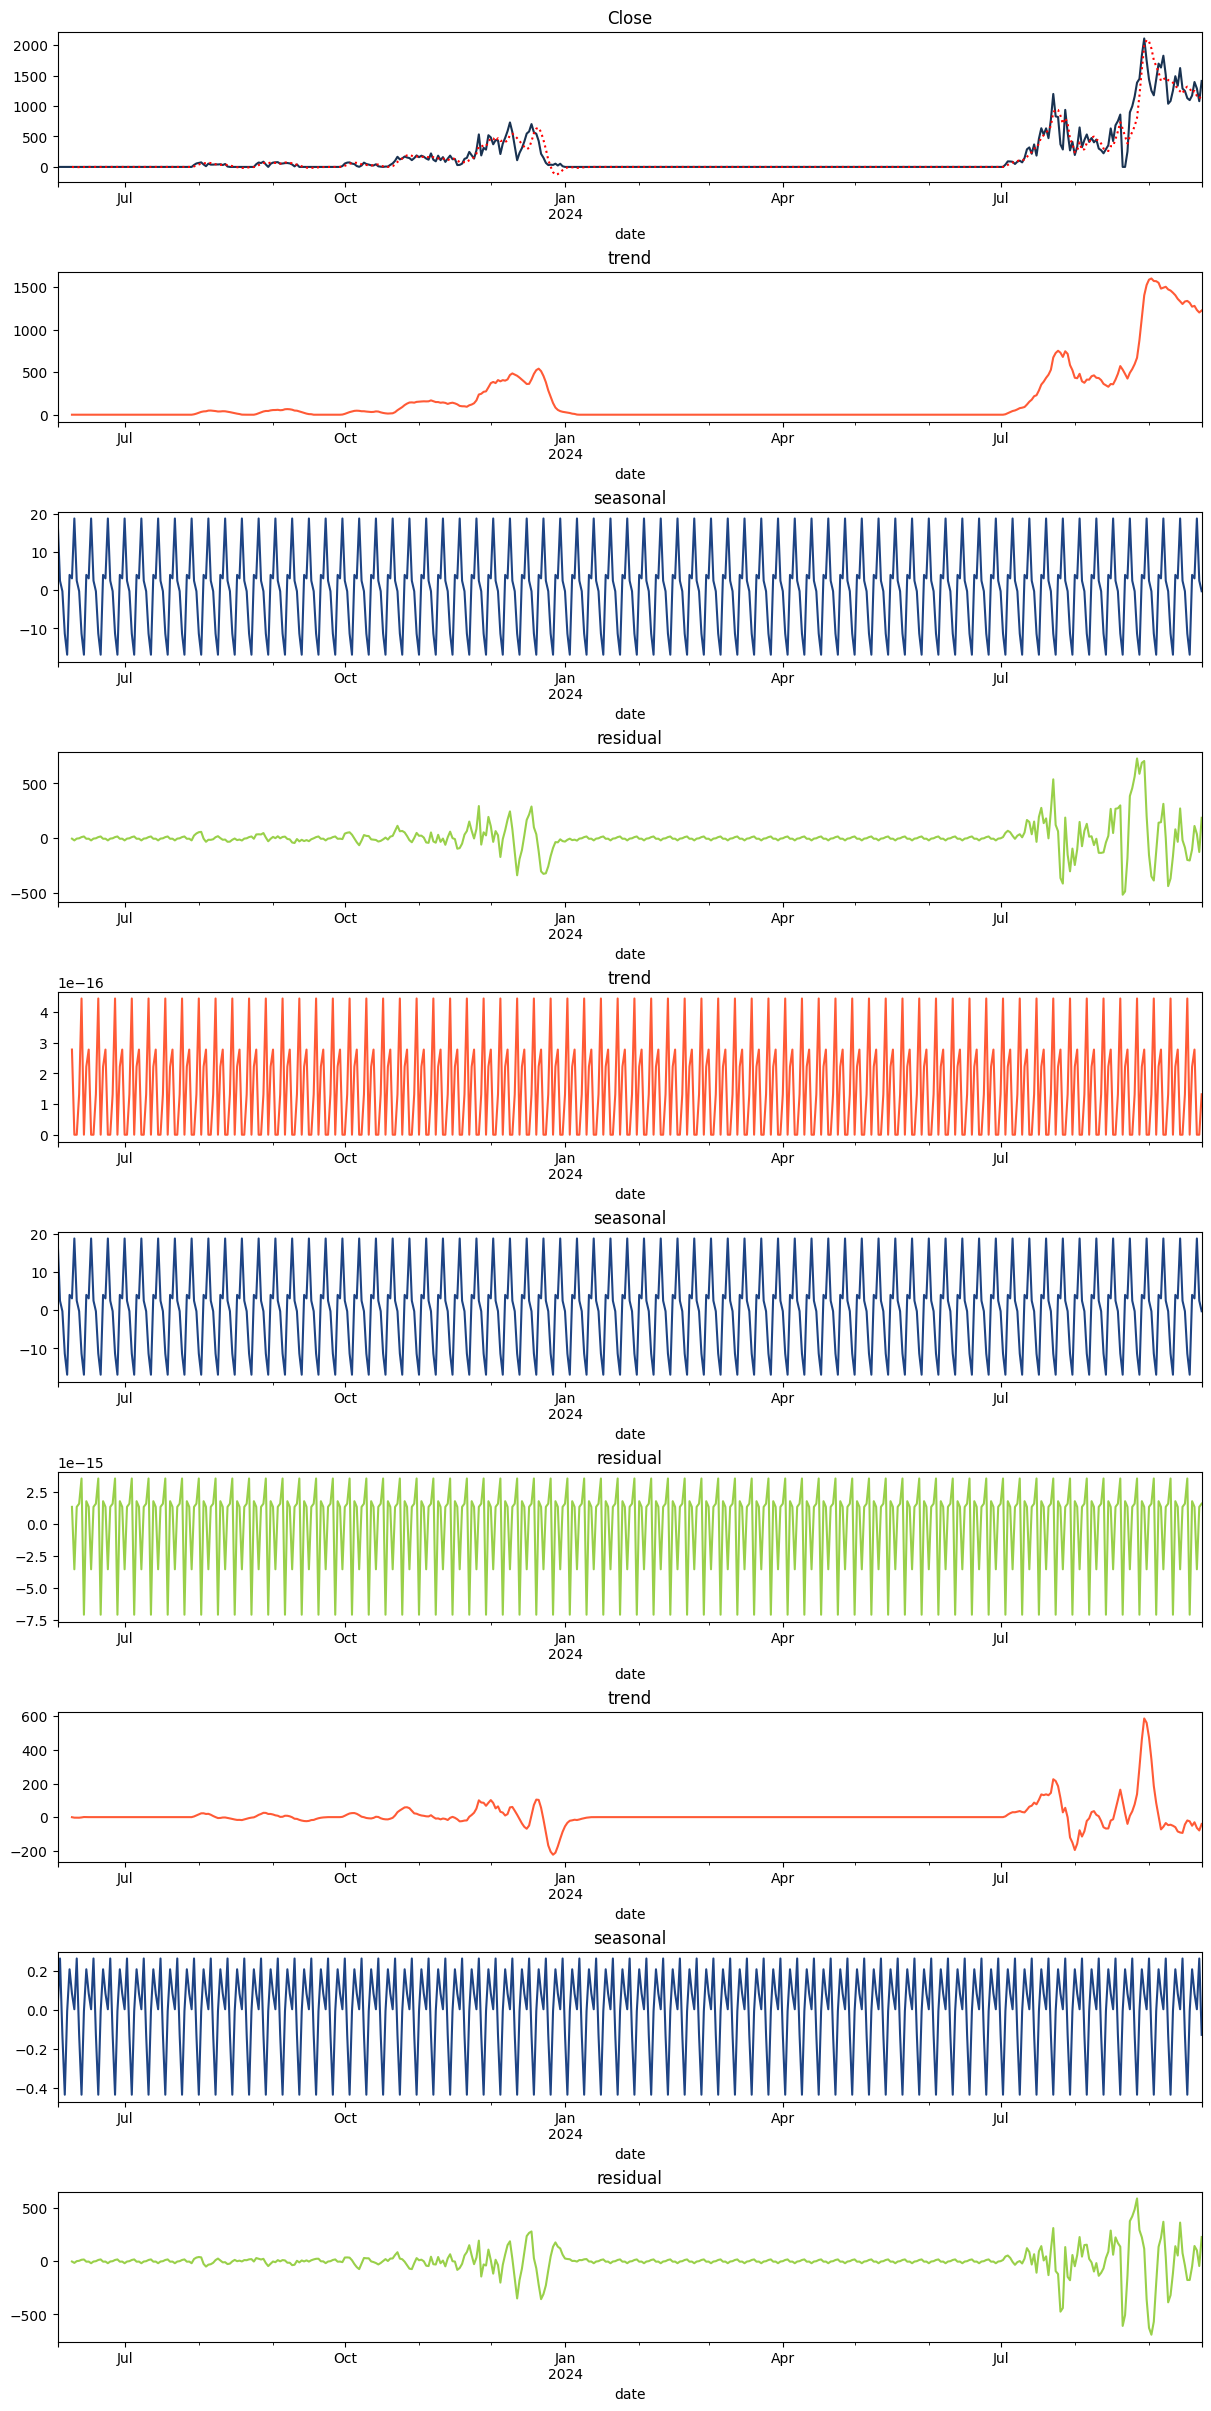

In [16]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition_year = seasonal_decompose(x=df_kwh_h_sum['kwh_sum'], 
                                   model='additive',
                                   two_sided=False,
                                   period=7)

fig, ax = plt.subplots(10, 1, figsize=(12, 24), constrained_layout=True)
decomposition_year.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Close')
decomposition_year.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition_year.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition_year.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')

decomposition_month = seasonal_decompose(x=decomposition_year.seasonal, 
                                   model='additive',
                                   two_sided=False,
                                   period=7)

decomposition_month.trend.plot(c=sns_c[1], ax=ax[4])
ax[4].set(title='trend')
decomposition_month.seasonal.plot(c=sns_c[2], ax=ax[5])
ax[5].set(title='seasonal')
decomposition_month.resid.plot(c=sns_c[3], ax=ax[6])
ax[6].set(title='residual')

decomposition_res = seasonal_decompose(x=decomposition_year.resid.fillna(0), 
                                   model='additive',
                                   two_sided=False,
                                   period=7)

decomposition_res.trend.plot(c=sns_c[1], ax=ax[7])
ax[7].set(title='trend')
decomposition_res.seasonal.plot(c=sns_c[2], ax=ax[8])
ax[8].set(title='seasonal')
decomposition_res.resid.plot(c=sns_c[3], ax=ax[9])
ax[9].set(title='residual')

decomposition_all = (decomposition_year.trend + decomposition_month.trend + decomposition_res.trend)

decomposition_all.plot(c='r', ax=ax[0], linestyle=':')